## Install the Required Libraries

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


## Import the Needed Libraries

In [2]:
import re
import nltk
import random
import pandas as pd
import numpy as np
from urllib import request
from nltk import pos_tag
from nltk.corpus import gutenberg, stopwords, wordnet
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from wordcloud import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.text import TSNEVisualizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import os
import multiprocessing
os.environ["OMP_NUM_THREADS"] = str(multiprocessing.cpu_count())
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objs as go

## Download the Required Packages

In [3]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('omw-1.4') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Al-Yousr
[nltk_data]     Store\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to C:\Users\Al-Yousr
[nltk_data]     Store\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Al-Yousr
[nltk_data]     Store\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Al-Yousr
[nltk_data]     Store\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Al-Yousr
[nltk_data]     Store\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Al-Yousr Store\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptro

# 1 - PREPROCESSING

### Function to get the Wordnet's Part of Speach for future use to lemmatize the words

In [4]:
def get_word_net_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else :
        return wordnet.NOUN

## Function "read_book"


* **It Takes 2 parameters the URL of the Book and the Name of the book**
* **It Reads the Book, Decode, lower the Characters, Remove the Unnecessary characters, Remove the Stopwords, and Tokenize them**


* **It Gets 200 Random Samples each Consists of 100 Word** 
* **Then, Using the Previous "get_word_net_pos" Function we lemmatize the Tokens and Label the Book with its Author name** 


* **Finally, We Return the Dataframe**








In [5]:
def read_book(url,name , word_num) :
    lemmatizer = WordNetLemmatizer()
    response = request.urlopen(url)
    lines = (response.read().decode('utf8')).lower()
    book = regexp_tokenize(lines,r'([a-zA-Z]{3,})[\,|\s|\.]')
    tokens = [token for token in book if token.lower() not in stop_words]
    books =[]
    for i in range(200) :
        start = random.randint(0 , len(tokens) - word_num)
        books.append([' '.join(tokens[start: start + word_num])])    
    df = pd.DataFrame(books, columns=["partitions"])
    for i in range(200):
        sent=""
        x = nltk.pos_tag((df.partitions[i]).split())
        for word,tag in x:
            lemma = lemmatizer.lemmatize(word,pos=get_word_net_pos(tag))
            sent += lemma+" "
            df.partitions[i] = sent
    df["author"] = name
    return df

## Function "five_books"


*   **It Takes the List of URLs of the Books and the Authors Lisr as parameters**
*   **And for each URL it Reads the Book and Preprocess it as Above then Append all of the Dataframes into a Full Dataframe Contains all the Books Samples** 



In [6]:
def five_books(list_of_urls,author_list , word_num) :
    df_full = pd.DataFrame()
    for i,j in enumerate(list_of_urls) :
        df = read_book(j,author_list[i] , word_num)
        df_full = df_full.append(df , ignore_index= True)
    return df_full    

# 2-VISUALIZATION

## Function "draw_chart"
* **To show the Word Denisty for all Books**

In [7]:
def draw_chart(all_books,author_list):
    for index in author_list:
        temp=all_books[all_books["author"]==index]
        wc = wordcloud.WordCloud(background_color='black', max_words=200, 
                             max_font_size=35)
        wc = wc.generate(str(temp))
        fig = plt.figure(num=1)
        plt.axis('off')
        plt.imshow(wc, cmap=None)
        plt.title(f'{index}')
        plt.show()

## Function "draw_chart_histogram"
 * **To Display the Characters' count for each Authors' Book**

In [8]:
def draw_chart_histogram(all_books,author_list):    
    x, y = "char_count", "y"
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(x, fontsize=12)
    
    for i in author_list:
        sns.distplot(all_books[all_books["author"]==i][x], hist=True, kde=False, 
                     bins=15, hist_kws={"alpha":0.8}, 
                     axlabel="histogram", ax=ax[0])
        sns.distplot(all_books[all_books["author"]==i][x], hist=False, kde=True, 
                     kde_kws={"shade":True}, axlabel="density",   
                     ax=ax[1])
    ax[0].grid(False)
    ax[0].legend(all_books["author"].unique())
    ax[1].grid(False)
    ax[0].legend(all_books["author"].unique())

    plt.show()

## Function get_top_n_words
* **To Display the most Repeated 20 Words**  

In [9]:
def get_top_n_words(corpus, n):
    vec = CountVectorizer(ngram_range=(1,1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## Function "draw_TSNE"
* **To Display the Scatter plot for each Book To see the Similarity between these Books**

In [10]:
def draw_TSNE (df_input):
    tsne = TSNEVisualizer()
    tsne.fit(df_input,df["author"])
    tsne.show()
    

# TRANSFORMATIONS

## Function bow 
 * **Convert the Text Dataframe into a Bag of Words Representation** 
 * **Then, Split the BOW Dataframe into Train and Test Sets**

In [11]:
def bow(df):
    vectorizer = CountVectorizer()
    bow_model = vectorizer.fit(df.partitions)
    X = bow_model.transform(df.partitions)
    df_bow = pd.DataFrame(X.toarray(),columns = bow_model.get_feature_names_out())
    X_train, X_test, y_train, y_test = train_test_split(df_bow, Y,stratify=Y  , test_size = 0.20, random_state = 42)
    return X_train, X_test, y_train, y_test, df_bow

## Function tf_idf
* **Convert the Text Dataframe into a TF_IDF  Representation** 
* **Then, Split the TF_IDF Dataframe into Train and Test Sets**

In [12]:
def tf_idf(df):
    vectorizer = TfidfVectorizer()
    tf_idf_model = vectorizer.fit(df.partitions)
    tf_idf_out=tf_idf_model.transform(df.partitions)
    feature_names = tf_idf_model.get_feature_names_out()
    dense = tf_idf_out.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    X_train, X_test, y_train, y_test = train_test_split(df, Y,stratify=Y  , test_size = 0.20, random_state = 42)
    return X_train, X_test, y_train, y_test,df 

## Function n_gram
 * **Convert the Text Dataframe into a N_Gram Representation**
 * **Then, Split the N_Gram Dataframe into Train and Test Sets**

In [13]:
def n_gram(df , n):
    count_vect = CountVectorizer(ngram_range=(n , n))
    ngram_vectors=count_vect.fit_transform(df.partitions)
    df = pd.DataFrame(ngram_vectors.toarray(),columns=count_vect.get_feature_names_out())
    X_train, X_test, y_train, y_test = train_test_split(df, Y,stratify=Y  ,test_size = 0.20, random_state = 42)

    return X_train, X_test, y_train, y_test,df

## cross_validation


* **this is user defined function which take estimator[fit ],x_train and y_test**
* **then path them to cross_val_score function to Evaluate a score by cross-validation.**
* **then return scores whice contain taining score and validation score**

In [14]:
cv =2
def cross_validation(model, X, y):
    scores = cross_val_score(model, X, y, cv=cv )
    return scores

## confusion_mx

* **this is user defined function which take y_test , y_predict and model_name**

* **then path them to confusion_matrix function**
* **to draw and calculate confusion_matrix**

In [15]:
def confusion_mx (y_test,y_pred,model_name):
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True,fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


##  bar_plot_val


* **this is user defined function which take results [list contain train and validation score]**

* **then draw bar chart to visualize train and validation score**

In [16]:
def bar_plot_val(results):
    test_score=results['test_score']
    train_score=results['train_score']
    X_axis = np.arange(len(test_score))
    plt.xticks(X_axis+3)
    plt.bar(X_axis-0.2, test_score, 0.4, color='black', label='Validation')
    plt.bar(X_axis+0.2, train_score, 0.4, color='red', label='Training')
    plt.legend()
    plt.show()

## model_fit

* **this is user defined function which take X_train ,y_train ,X_test,y_test,model and model_name**

* **then path X_train and y_train to fit function then path X_test to  predict functoin to calculate  y_pred**

* **then path X_train , y_train and estimator with 10 k_fold  to cross_validate fun**

* **then path the results from cross_validate to bar_plot_val function** 

* **then path y_test ,y_pred and model_name**

In [17]:
def model_fit(X_train, y_train, X_test, y_test, model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results = cross_validate(estimator=model, X=X_train, y=y_train, cv=cv, return_train_score=True)
    print(f"Score {model_name} ",end="")
    print(cross_validation(model,X_train,y_train))
    bar_plot_val(results)
    confusion_mx(y_test, y_pred,model_name)
    
    

## svm

* **this is user defined function whice apply  SVM model  using \"rbf\" kernel**
* **then calculate cross_validation for all three Transform**
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [18]:
def svm():
    svc = SVC(kernel="rbf")
    model_fit(X_train_bow, y_train_bow, X_test_bow, y_test_bow, svc,"SVM BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,svc,"SVM TF_IDF")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,svc,"SVM 2_GRAM")
    model_fit(X_train_3_gram, y_train_3_gram, X_test_3_gram, y_test_3_gram,svc,"SVM 3_GRAM")


## naive_bayes
  
* **this is user defined function whice apply  naive_bayes model**  
* **then calculate cross_validation for all three Transform**
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [19]:
from sklearn.naive_bayes import MultinomialNB

def naive_bayes():
    nb = MultinomialNB()
    model_fit(X_train_bow, y_train_bow,X_test_bow,y_test_bow,nb,"Naïve Bayes BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,nb,"Naïve Bayes TF_IDF")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,nb,"Naïve Bayes N_GRAM")
    model_fit(X_train_3_gram, y_train_3_gram ,X_test_3_gram, y_test_3_gram,nb,"Naïve Bayes 3_GRAM")

## knn
* **this is user defined function whice apply  KNeighborsClassifier model  with k = 5**
* **then calculate cross_validation for all three Transform**
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [20]:
def knn():
    k = 5  # Set the value of k for KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    model_fit(X_train_bow, y_train_bow,X_test_bow,y_test_bow,knn,"KNN BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,knn,"KNN TF_IDF")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,knn,"KNN 2_GRAM")
    model_fit(X_train_3_gram, y_train_3_gram ,X_test_3_gram, y_test_3_gram,knn,"KNN 3_GRAM")
    

## RandomForest
* **this is user defined function whice apply  RandomForestClassifier model**
* **then calculate cross_validation for all three Transform**
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [21]:
def RandomForest():
    Forest_model = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 42)
    model_fit(X_train_bow, y_train_bow,X_test_bow,y_test_bow,Forest_model,"Random Forest BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,Forest_model,"Random Forest TF_IDF")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,Forest_model,"Random Forest 2_GRAM")
    model_fit(X_train_3_gram, y_train_3_gram ,X_test_3_gram, y_test_3_gram,Forest_model,"Random Forest 3_GRAM")


## SGD
* **this is user defined function whice apply  SGDClassifier model**
* **then calculate cross_validation for all three Transform**
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [22]:
def SGD():
    sgd = SGDClassifier(random_state=42)
    model_fit(X_train_bow, y_train_bow,X_test_bow,y_test_bow,sgd,"SGD BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,sgd,"SGD TF_IDF")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,sgd,"SGD 2_GRAM")
    model_fit(X_train_3_gram, y_train_3_gram, X_test_3_gram, y_test_3_gram,sgd,"SGD 3_GRAM")


## xgb_m

* **this is user defined function whice apply  XGBClassifier model**
* **then calculate cross_validation for all three Transform\n**",
* **[ BOW, and TF-IDF, n-gram]**
* **then calculate model_fit  for all three Transform [ BOW, and TF-IDF, n-gram]**

In [23]:
def xgb_m():
    xgb_model = xgb.XGBClassifier(random_state=42)
    model_fit(X_train_bow, y_train_bow,X_test_bow,y_test_bow,xgb_model,"XGB BOW")
    model_fit(X_train_tf_idf,y_train_tf_idf, X_test_tf_idf,  y_test_tf_idf,xgb_model,"XGB TF_IDF")
    model_fit(X_train_n_gram, y_train_n_gram, X_test_n_gram, y_test_n_gram,xgb_model,"XGB 2_GRAM")
    model_fit(X_train_3_gram, y_train_3_gram, X_test_3_gram, y_test_3_gram,xgb_model,"XGB 3_GRAM")


## Get 5 Books from Gutenberg Library 


*  **The Project Gutenberg EBook of The Adventures of Pinocchio, by C. Collodi--Pseudonym of Carlo Lorenzini**

*  **The Project Gutenberg eBook of Peter Pan, by James M. Barrie**

*  **The Project Gutenberg eBook of The Wonderful Wizard of Oz, by L. Frank Baum**

*  **The Project Gutenberg eBook of Alice’s Adventures in Wonderland, by Lewis Carroll**

*  **The Project Gutenberg eBook of Gulliver’s Travels, by Jonathan Swift**








In [24]:
pinocchio = "https://www.gutenberg.org/files/500/500-0.txt"
pan = "https://www.gutenberg.org/files/16/16-0.txt"
oz = "https://www.gutenberg.org/files/55/55-0.txt"
alice = "https://www.gutenberg.org/files/11/11-0.txt"
gulliver = "https://www.gutenberg.org/files/829/829-0.txt"
books_list = [pinocchio , pan , oz , alice , gulliver]
author_list = ["Carlo Collodi", "James M. Barrie", "L. Frank Baum", "Lewis Carroll", "Jonathan Swift"]

In [25]:
df = five_books(books_list,author_list, 100)

In [26]:
df.author.value_counts()

Carlo Collodi      200
James M. Barrie    200
L. Frank Baum      200
Lewis Carroll      200
Jonathan Swift     200
Name: author, dtype: int64

In [27]:
df['char_count'] = df["partitions"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df.head()

,partitions,author,char_count
0,five plaster heavy answer pinocchio work hard ...,Carlo Collodi,497
1,one boy wear driver imagine little fat man muc...,Carlo Collodi,480
2,marionette fairy asleep wish disturb pinocchio...,Carlo Collodi,499
3,suffer terribly use firewood poor old feel sor...,Carlo Collodi,520
4,roared voice thunder mouth stop laugh stick lo...,Carlo Collodi,494


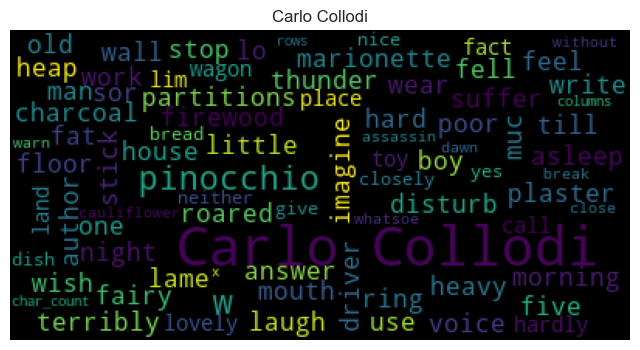

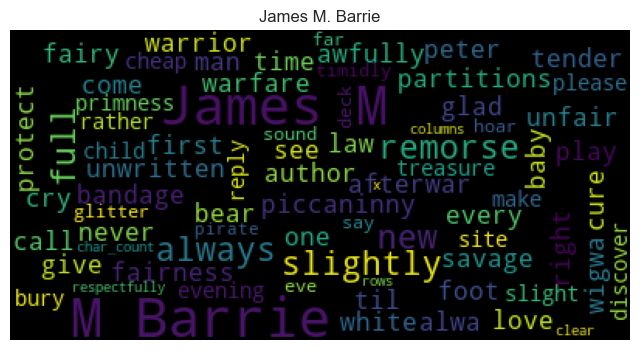

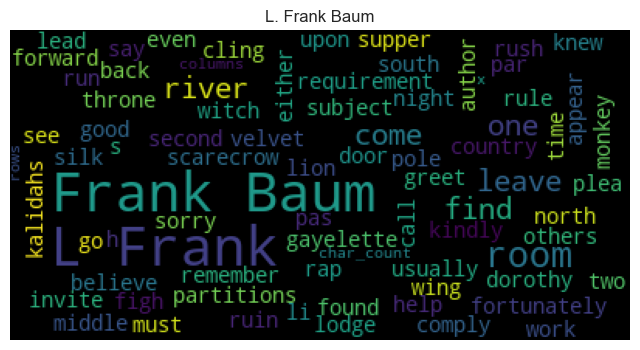

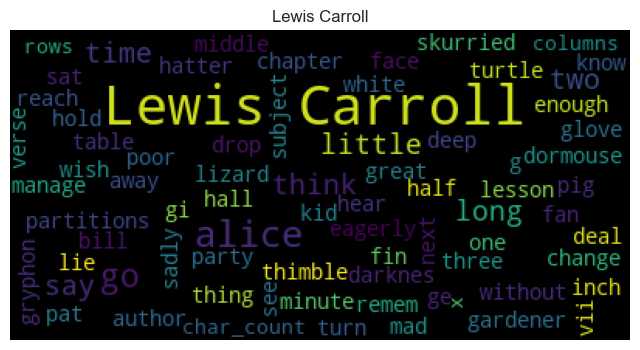

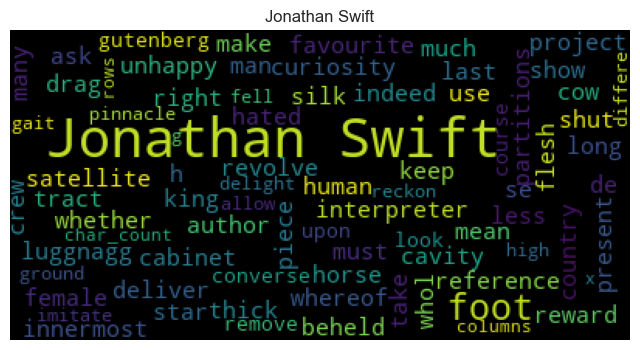

In [28]:
draw_chart(df,author_list)

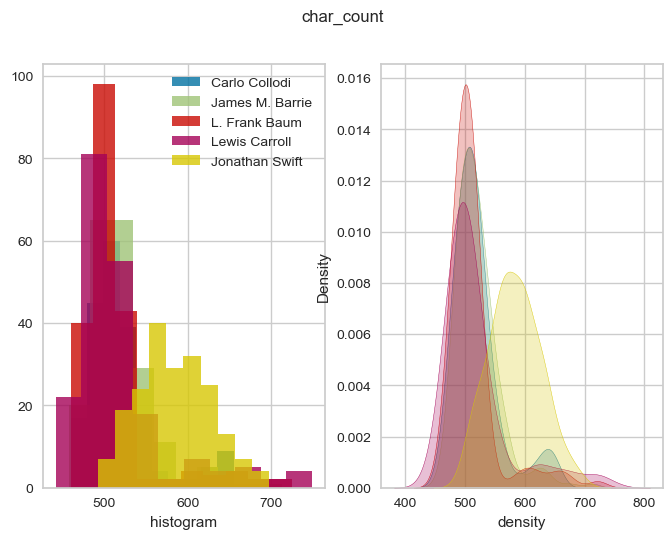

In [29]:
draw_chart_histogram(df,author_list)

In [30]:
Y = df.author
Y

0       Carlo Collodi
1       Carlo Collodi
2       Carlo Collodi
3       Carlo Collodi
4       Carlo Collodi
            ...      
995    Jonathan Swift
996    Jonathan Swift
997    Jonathan Swift
998    Jonathan Swift
999    Jonathan Swift
Name: author, Length: 1000, dtype: object

<AxesSubplot:title={'center':'Top 20 words'}, xlabel='word'>

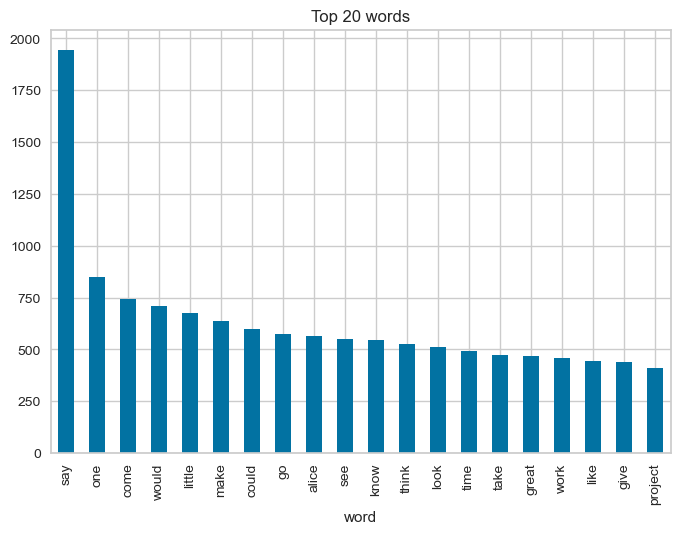

In [31]:
common_words = get_top_n_words(df['partitions'], 20)
df1 = pd.DataFrame(common_words, columns = ['word' , 'count'])
df1.groupby('word').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 20 words')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

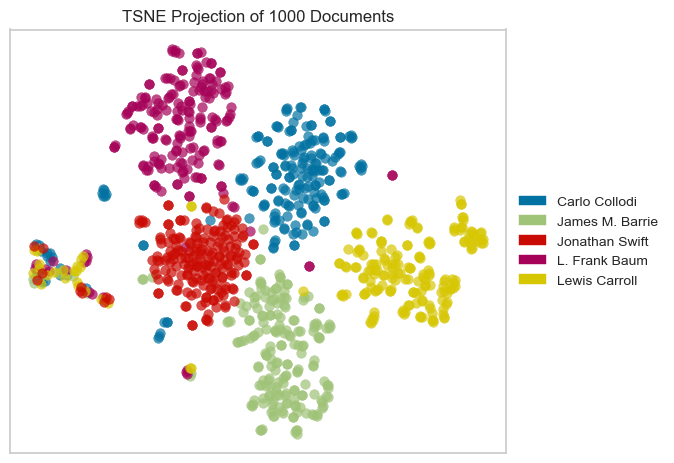

In [32]:
a = bow(df,0.20)
draw_TSNE(a[4])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

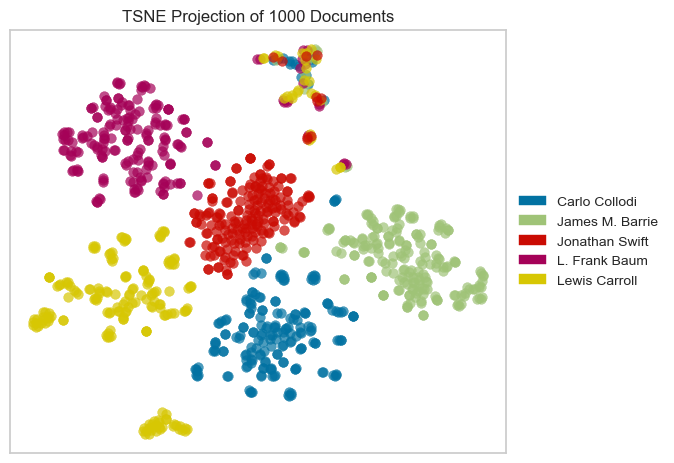

In [33]:
t = tf_idf(df,0.20)
draw_TSNE(t[4])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

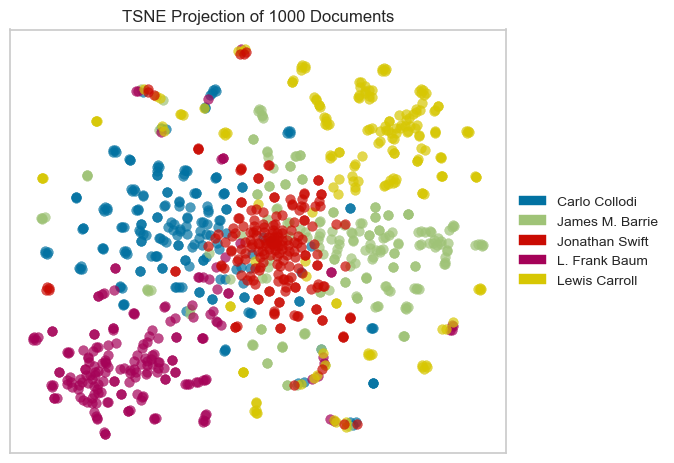

In [34]:
g = n_gram(df,2,0.20)
draw_TSNE(g[4])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

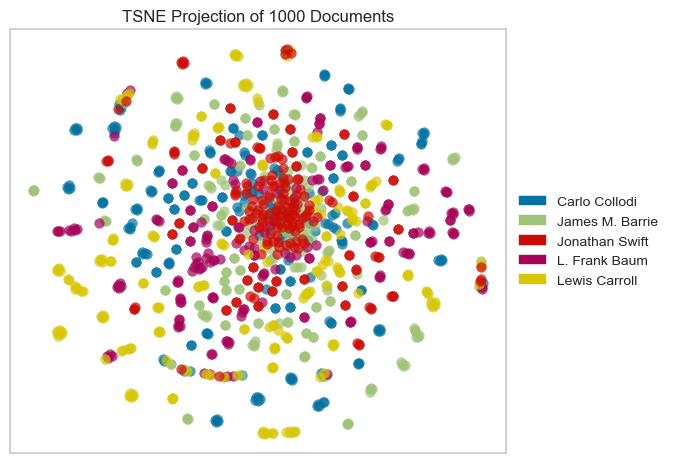

In [35]:
g = n_gram(df,3,0.20)
draw_TSNE(g[4])

In [36]:
encoder = LabelEncoder()
df.author = encoder.fit_transform(df.author)
Y = df.author
Y

0      0
1      0
2      0
3      0
4      0
      ..
995    2
996    2
997    2
998    2
999    2
Name: author, Length: 1000, dtype: int32

In [37]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow,hh = bow(df,0.20)
X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf,tt = tf_idf(df,0.20)
X_train_n_gram, X_test_n_gram, y_train_n_gram, y_test_n_gram,gg = n_gram(df,2,0.20)
X_train_3_gram, X_test_3_gram, y_train_3_gram, y_test_3_gram,gg = n_gram(df,3,0.20)

In [38]:
X_train_bow

,aback,abandon,abbot,abet,abhor,abide,abject,ablaze,able,ablest,...,yore,young,youngster,youth,zealand,zealot,zealous,zigzag,zip,zum
231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
544,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
523,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Score SVM BOW [0.9625 0.95   0.9375 0.925  0.9625 0.95   0.9125 0.9625 0.9625 0.925 ]


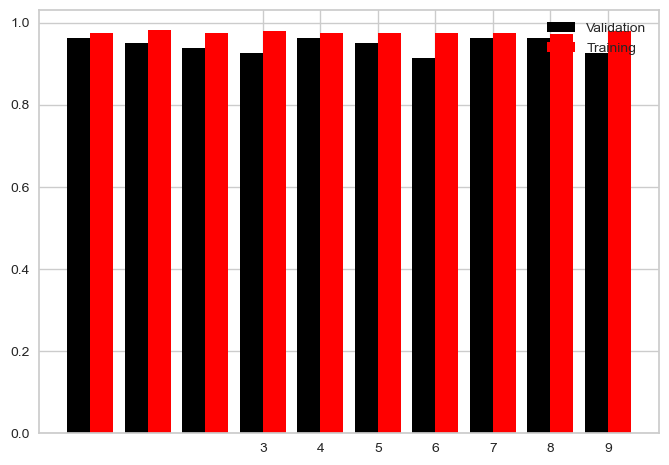

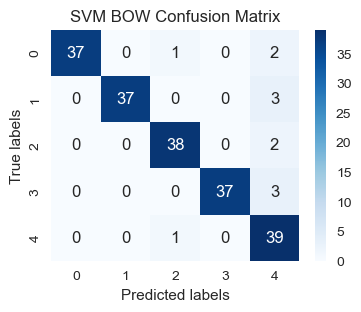

Score SVM TF_IDF [0.9625 0.95   0.9375 0.925  0.9625 0.9375 0.9125 0.975  0.9375 0.925 ]


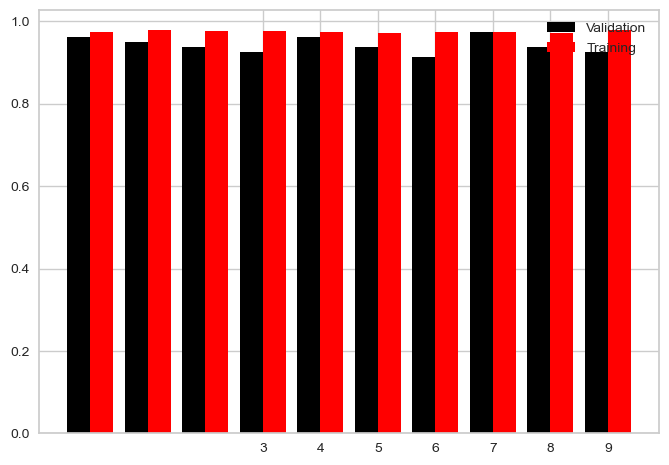

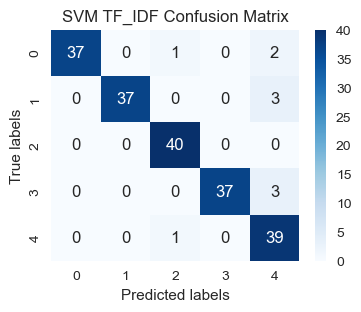

Score SVM 2_GRAM 

In [ ]:
svm()

In [ ]:
naive_bayes()

In [ ]:
knn()

In [ ]:
RandomForest()

In [ ]:
SGD()

In [ ]:
xgb_m() 

In [ ]:
# df = five_books(books_list,author_list, 50)

## Error-Analysis


*  **Check Balance of a dataset**

*  **Change Size of training and validation dataset**

*  **Change**



In [ ]:
Count_num_or_Rows=df.groupby('author').size().reset_index()
# Grouped data and using sum method to have count of Hospital overall rating.
Count_num_or_Rows=Count_num_or_Rows.rename(columns = {0:'count'})
#Count_num_or_Rows

In [ ]:
Count_num_or_Rows______bar=px.bar(Count_num_or_Rows,x='author',y='count',barmode='group',
                title='Count_num_or_Rows',
                color_discrete_sequence=px.colors.sequential.solar)
#apply specific colors using 'color_discrete_map' to have a sequence of colors.
#item_bar.update_xaxes(categoryorder='total descending') #Sort bars in descending order.
Count_num_or_Rows______bar.show()

# So We notice that dataset is Balance

In [ ]:
df = five_books(books_list,author_list, 40)

In [ ]:
df.author.value_counts()

In [ ]:
df['char_count'] = df["partitions"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df.head()

In [ ]:
draw_chart(df,author_list)

In [ ]:
draw_chart_histogram(df,author_list)

In [ ]:
Y = df.author
Y


In [ ]:
common_words = get_top_n_words(df['partitions'], 20)
df1 = pd.DataFrame(common_words, columns = ['word' , 'count'])
df1.groupby('word').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 20 words')



In [ ]:
a = bow(df,0.15)
draw_TSNE(a[4])


In [ ]:
t = tf_idf(df,0.15)
draw_TSNE(t[4])

In [ ]:
g = n_gram(df,2,0.15)
draw_TSNE(g[4])

In [ ]:
g = n_gram(df,3,0.15)
draw_TSNE(g[4])

In [ ]:
encoder = LabelEncoder()
df.author = encoder.fit_transform(df.author)
Y = df.author
Y

In [ ]:

X_train_bow, X_test_bow, y_train_bow, y_test_bow,hh = bow(df,0.15)
X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf,tt = tf_idf(df,0.15)
X_train_n_gram, X_test_n_gram, y_train_n_gram, y_test_n_gram,gg = n_gram(df,2,0.15)
X_train_3_gram, X_test_3_gram, y_train_3_gram, y_test_3_gram,gg = n_gram(df,3,0.15)



In [ ]:
X_train_bow

In [ ]:
svm()

In [ ]:
naive_bayes()

In [ ]:
knn()

In [ ]:
RandomForest()

In [ ]:
SGD()

In [ ]:
xgb_m() 